In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-05-29'
end_day_to_analyze = '2020-05-30'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,3498,1252,AXLA,buy,513,6.09,"{'avg': 5.8662, 'rsi': 68.66334039377884, 'mac...",2020-05-29 14:22:52.942402+00:00,2020-05-29 14:22:53.401478,5.91,6.63
1,3499,1252,AXLA,sell,513,5.87,"{'avg': 5.8708, 'rsi': [51.02963132045023, 42....",2020-05-29 14:26:16.430766+00:00,2020-05-29 14:26:16.934394,5.91,6.63
2,3507,1250,DVAX,buy,316,5.91,"{'avg': 5.8708, 'rsi': 60.65339535562625, 'mac...",2020-05-29 15:05:18.889954+00:00,2020-05-29 15:06:12.420802,5.64,6.81
3,3511,1250,DVAX,sell,316,5.62,"{'avg': 5.8607, 'rsi': [46.84136789949919, 35....",2020-05-29 15:34:57.393271+00:00,2020-05-29 15:36:10.508510,5.64,6.81
4,3516,1250,DVAX,buy,342,5.70,"{'avg': 5.8269, 'rsi': 62.223041467699936, 'ma...",2020-05-29 16:05:45.309082+00:00,2020-05-29 16:06:19.140362,5.44,6.52
5,3523,1250,DVAX,sell,342,5.73,"{'avg': 5.8009, 'rsi': [64.11685305742361, 63....",2020-05-29 17:24:06.458607+00:00,2020-05-29 17:25:14.419950,5.44,6.52
6,3508,1253,FLGT,buy,297,17.20,"{'avg': 16.9968, 'rsi': 62.06008429765858, 'ma...",2020-05-29 15:14:12.821669+00:00,2020-05-29 15:15:22.166395,16.89,18.13
7,3512,1253,FLGT,sell,297,17.42,"{'avg': 17.0489, 'rsi': [64.52498996481155, 58...",2020-05-29 15:46:05.302023+00:00,2020-05-29 15:48:00.300566,16.89,18.13
8,3501,1251,GFI,buy,1086,7.79,"{'avg': 7.7407, 'rsi': 64.30251023429108, 'mac...",2020-05-29 14:41:41.349124+00:00,2020-05-29 14:41:41.654539,7.70,8.04
9,3505,1251,GFI,sell,1086,7.70,"{'avg': 7.7509, 'rsi': [33.51527094975387, 30....",2020-05-29 15:02:29.536349+00:00,2020-05-29 15:03:38.224622,7.70,8.04


In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)
algo_runs.set_index('algo_run_id', inplace=True)

In [8]:
algo_runs

,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason,batch_id
algo_run_id,,,,,,,,
1250,momentum_long,PAPER,v0.1-463-g1e31f4f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-05-29 13:45:36.456959,None,None,a6498198-ed3d-4316-97a1-85620eadbf28
1251,momentum_long,PAPER,v0.1-463-g1e31f4f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-05-29 13:45:37.348631,None,None,a6498198-ed3d-4316-97a1-85620eadbf28
1252,momentum_long,PAPER,v0.1-463-g1e31f4f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-05-29 13:45:38.648520,None,None,a6498198-ed3d-4316-97a1-85620eadbf28
1253,momentum_long,PAPER,v0.1-463-g1e31f4f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-05-29 13:45:39.706938,None,None,a6498198-ed3d-4316-97a1-85620eadbf28
1254,momentum_long,PAPER,v0.1-463-g1e31f4f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-05-29 13:45:40.967971,None,None,a6498198-ed3d-4316-97a1-85620eadbf28


In [9]:
algo_runs.loc[1011]

KeyError: 1011

In [10]:
trade_details = {}
batch = {}
for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    batch_id = algo_runs.loc[algo_run_id]['batch_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))
    if batch_id not in batch:
        batch[batch_id] = []
    if algo_run_id not in batch[batch_id]:
        #print(batch_id, algo_run_id)
        batch[batch_id].append(algo_run_id)

In [11]:
revenues = {}
how_was_my_day = {}

for batch_id, count in batch.items():
    revenues[batch_id] = []
    symbol_name = []
    counts = []
    for run_id in batch[batch_id]:
        
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            revnue = 0
            for trade in trade_details[run_id][symbol]:
                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                revnue += delta

            revenues[batch_id].append(revnue)
            counts.append(count)
            symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[batch_id],
    }
    how_was_my_day[batch_id] = pd.DataFrame(data=d)

In [12]:
for batch_id, how_did_i_do in how_was_my_day.items():
    #display(HTML(algo_runs.loc[algo_runs['batch_id'] == batch_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[batch_id]).sum().round(2)} $ for {batch_id}')


,symbol,count,revenue
3,GHG,1,-6988.41
2,VIVO,2,-4574.11
9,TRVI,1,-3828.00
6,SNOA,2,-464.10
1,AXLA,2,-112.86
0,SILJ,4,-112.35
10,GFI,2,-97.74
4,DVAX,4,-81.38
5,ZNGA,2,28.85
7,SLGG,2,44.13


TOTAL REVENUE: -16007.77 $ for a6498198-ed3d-4316-97a1-85620eadbf28


In [16]:
minute_history = {}
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            if symbol not in minute_history:
                minute_history[symbol] = api.polygon.historic_agg_v2(
                    symbol, 
                    1, 
                    'minute',
                    _from = str((datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date()),
                    to=str((datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date())).df


In [17]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4, minutes=1)
    #print(now)
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    #print(minute_history["close"][minute_history_index-10:minute_history_index])
    for back_track_min in range(120, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().between_time("9:30", "16:00").resample("5min").max()
        ).dropna()
        #print(series[-10:])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                #print([i for i in high_index if series[i] >= current_value])
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(120, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

SILJ analysis for run 1252 with profit -112.35


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7877.25,-7877.25,buy,2020-05-29 14:47:30.042586,11.67,"[11.5499, 11.55, 11.565]","[11.7942, 11.82, 11.835]",675,"{'avg': 11.573, 'rsi': 68.7334191643619, 'macd': [0.014166994938834776, 0.017823549111628978, 0.018889811792744737, 0.01950993427176506, 0.022701085111204833], 'vwap': 11.6767, 'supports': [11.0501, 11.06, 11.0639, 11.09, 11.5499, 11.55, 11.565], 'sell_macd': [0.00716861444839445, 0.009633883261793486, 0.010390795541560749, 0.010845651921359334, 0.012965726348198814], 'slow macd': [0.046374280858746175, 0.046436220392891414, 0.04609906644906836, 0.045715145021425485, 0.04587577525529696], 'macd_signal': [0.012179304681185901, 0.013308153567274517, 0.014424485212368561, 0.015441575024247861, 0.016893477041639255], 'resistances': [11.7942, 11.82, 11.835], 'position_ratio': '1.05', 'sell_macd_signal': [0.0053479461877506285, 0.0062051336025592, 0.00704226599035951, 0.007802943176559475, 0.008835499810887344]}",12.09,11.54
1,-6.75,7870.50,sell,2020-05-29 15:04:23.165922,11.66,None,None,675,"{'avg': 11.6025, 'rsi': [63.136179529391804, 63.105784853687894], 'vwap': 11.7412, 'reasons': 'bail', 'movement': 0.005998286203941755, 'sell_macd': [0.02325101566331078, 0.02285103667461108, 0.022663377246082916, 0.021703339025853197, 0.020668200944818693], 'sell_macd_signal': [0.020111014763967754, 0.02065901914609642, 0.02105989076609372, 0.021188580418045617, 0.021084504523400233]}",12.09,11.54
2,-15661.95,-15655.20,buy,2020-05-29 16:15:50.171229,11.86,[11.8099],"[11.9, 11.91, 11.91, 11.91, 11.91, 11.91, 11.91, 11.92]",1320,"{'avg': 11.6392, 'rsi': 62.1708816104239, 'macd': [0.013763939350770471, 0.013702077179734928, 0.015092902234567163, 0.016010581098216292, 0.016547103500240468], 'vwap': 11.8594, 'supports': [11.5499, 11.55, 11.565, 11.6501, 11.6959, 11.74, 11.75, 11.8099], 'sell_macd': [0.007545926604487718, 0.007522425656460996, 0.008445380428694804, 0.009054885700191306, 0.009412228954603918], 'slow macd': [0.026581456546985294, 0.026386387141890566, 0.02648458776176632, 0.026532577076155306, 0.026534293631176098], 'macd_signal': [0.016209745865998777, 0.015708212128746006, 0.015585150149910238, 0.015670236339571448, 0.015845609771705252], 'resistances': [11.91, 11.91, 11.91], 'position_ratio': '1.0', 'sell_macd_signal': [0.00913205888449706, 0.008810132238889847, 0.008737181876850839, 0.008800722641518932, 0.00892302390413593]}",12.07,11.79
3,-112.35,15549.60,sell,2020-05-29 16:37:05.184959,11.78,None,None,1320,"{'avg': 11.6507, 'rsi': [41.52671812046913, 35.457565358141025], 'vwap': 11.7821, 'reasons': 'stopped', 'movement': -0.006745362563237781, 'sell_macd': [0.0006919509496174925, -0.0006758860959301671, -0.0022524359223847767, -0.0032750405154367, -0.0052449266851457566], 'sell_macd_signal': [0.0029368284558809114, 0.0022142855455186956, 0.001320941251938001, 0.0004017448984630608, -0.0007275894182587027]}",12.07,11.79


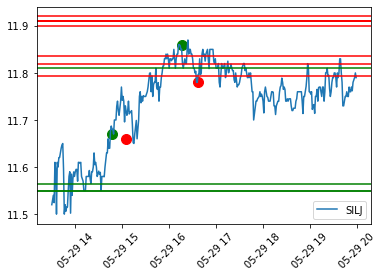

AXLA analysis for run 1252 with profit -112.86


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3124.17,-3124.17,buy,2020-05-29 14:22:53.401478,6.09,[5.92],[6.35],513,"{'avg': 5.8662, 'rsi': 68.66334039377884, 'macd': [0.028887524261658193, 0.03786231231650827, 0.048450966065277434, 0.051408447309295724, 0.053937431790401114], 'vwap': 6.09, 'supports': [5.68, 5.8375, 5.92, 5.98, 5.99, 5.99], 'sell_macd': [0.018685655055156403, 0.024379245334809063, 0.03109659821071009, 0.032810164111273465, 0.0342387847596175], 'slow macd': [-0.0013109524310035425, 0.0015503728574888243, 0.004980084171918975, 0.007167947185839907, 0.009329323038014259], 'macd_signal': [0.020695177091030366, 0.02412860413612595, 0.028993076521956245, 0.03347615067942414, 0.037568406901619535], 'resistances': [6.35], 'position_ratio': '2.6', 'sell_macd_signal': [0.01395258735977763, 0.016037918954783917, 0.01904965480596915, 0.021801756667030013, 0.024289162285547512]}",6.63,5.91
1,-112.86,3011.31,sell,2020-05-29 14:26:16.934394,5.87,None,None,513,"{'avg': 5.8708, 'rsi': [51.02963132045023, 42.87521322801224], 'vwap': 5.938, 'reasons': 'stopped', 'movement': -0.029556650246305372, 'sell_macd': [0.032810164111273465, 0.033719304240136694, 0.032431370519249825, 0.02737023553519169, 0.01943467274845556], 'sell_macd_signal': [0.021801756667030013, 0.02418526618165135, 0.025834487049171045, 0.026141636746375173, 0.02480024394679125]}",6.63,5.91


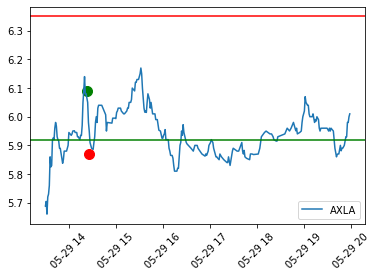

VIVO analysis for run 1252 with profit -4574.11


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9323.40,-9323.40,buy,2020-05-29 15:49:07.163337,15.16,"[14.82, 15.0, 15.055]",[16.0],615,"{'avg': 14.9217, 'rsi': 67.18716033811289, 'macd': [0.034867775595911255, 0.03193249390294817, 0.031662031107572375, 0.032684750785184846, 0.03550671348661716], 'vwap': 15.1672, 'supports': [14.75, 14.78, 14.78, 15.0, 15.055], 'sell_macd': [0.019837735551385904, 0.017921246389240864, 0.017753576309786467, 0.018431319412682612, 0.020278504695294686], 'slow macd': [0.04352117718924653, 0.04311176971383546, 0.0431459585663827, 0.04342827952417849, 0.04409837444852549], 'macd_signal': [0.03778495739711388, 0.03661446469828074, 0.03562397798013907, 0.03503613254114822, 0.03513024873024201], 'resistances': [16.0], 'position_ratio': '7.22', 'sell_macd_signal': [0.021882146015737312, 0.021089966090438023, 0.020422688134307712, 0.020024414389982693, 0.020075232451045092]}",15.62,15.02
1,-4574.11,4749.29,sell,2020-05-29 17:13:22.147269,15.47,None,None,307,"{'avg': 15.0114, 'rsi': [72.89235916690812, 73.97113602167049], 'vwap': 15.4667, 'reasons': 'scale-out', 'movement': 0.02044854881266494, 'sell_macd': [0.017582270861908, 0.018266536975801273, 0.020006659441486718, 0.022661213837585237, 0.024954876823668926], 'sell_macd_signal': [0.01627616008203691, 0.016674235460789784, 0.01734072025692917, 0.018404818973060382, 0.019714830543182092]}",15.62,15.02


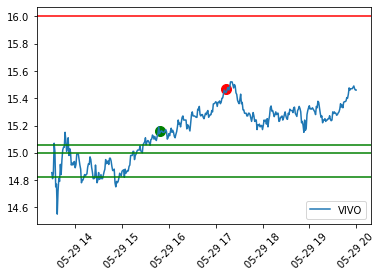

GHG analysis for run 1252 with profit -6988.41


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6988.41,-6988.41,buy,2020-05-29 14:54:41.730809,12.87,[12.71],[13.0],543,"{'avg': 12.6621, 'rsi': 62.194010657214505, 'macd': [0.004999606957085234, 0.0057127452285108404, 0.008599531677877081, 0.013555281384043383, 0.020075537918685882], 'vwap': 12.87, 'supports': [11.71, 11.9354, 11.954, 11.97, 11.97, 12.02, 12.55, 12.68, 12.71], 'sell_macd': [0.00011879959282623531, 0.0007888976290217897, 0.0028592480776268303, 0.006253556893714318, 0.010635439647890266], 'slow macd': [0.07218252311652229, 0.07067763103831837, 0.0696598512717852, 0.06917182622265194, 0.06917197298676747], 'macd_signal': [0.01186174452719573, 0.010631944667458752, 0.010225462069542418, 0.01089142593244261, 0.012728248329691265], 'resistances': [13.0], 'position_ratio': '0.81', 'sell_macd_signal': [0.00356904241056289, 0.0030130134542546696, 0.0029822603789291017, 0.003636519681886145, 0.00503630367508697]}",13.38,12.69


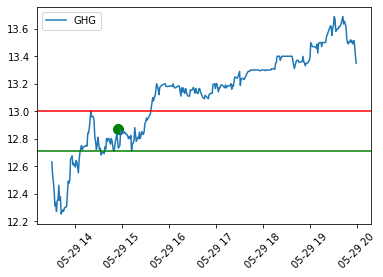

DVAX analysis for run 1250 with profit -81.38


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1867.56,-1867.56,buy,2020-05-29 15:06:12.420802,5.91,"[5.135, 5.165, 5.675]",[6.3339],316,"{'avg': 5.8708, 'rsi': 60.65339535562625, 'macd': [0.010112970701297463, 0.014382142939112441, 0.020355059730118086, 0.029987914085120693, 0.038094704088782905], 'vwap': 5.9377, 'supports': [5.135, 5.165, 5.675], 'sell_macd': [-0.002138871720691604, 0.0011552724363310674, 0.0055253162932791255, 0.012235411294883924, 0.01789216829230522], 'slow macd': [0.1064370754825461, 0.10523123804218226, 0.10451330245543833, 0.10472520849505429, 0.10493340320244204], 'macd_signal': [0.0414310277991594, 0.036021250827150006, 0.03288801260774362, 0.032307992903219035, 0.03346533514033181], 'resistances': [6.3339], 'position_ratio': '1.57', 'sell_macd_signal': [0.016878314331029418, 0.013733705952089748, 0.012092028020327623, 0.012120704675238883, 0.013274997398652151]}",6.81,5.64
1,-91.64,1775.92,sell,2020-05-29 15:36:10.508510,5.62,None,None,316,"{'avg': 5.8607, 'rsi': [46.84136789949919, 35.85326128055399], 'vwap': 5.6421, 'reasons': 'stopped', 'movement': -0.04737732656514387, 'sell_macd': [-0.0017123535631586861, -0.002852629743360424, -0.002145667939059237, -0.0031253643520834373, -0.00956246072129563], 'sell_macd_signal': [-0.004097468887180605, -0.0038485010584165687, -0.0035079344345451025, -0.0034314204180527696, -0.004657628478701341]}",6.81,5.64
2,-2041.04,-1949.40,buy,2020-05-29 16:06:19.140362,5.70,[5.485],"[5.785, 5.79]",342,"{'avg': 5.8269, 'rsi': 62.223041467699936, 'macd': [0.0039049605323899783, 0.00711864496645731, 0.010751945933701101, 0.015470321951529087, 0.020179359322174406], 'vwap': 5.7099, 'supports': [5.135, 5.4687, 5.675], 'sell_macd': [0.005281982673141172, 0.007203245449587392, 0.009386005464355307, 0.01226366254775435, 0.015120750371861114], 'slow macd': [-0.00402770943464148, -0.0033664013562137995, -0.0025126886437440987, -0.0013233868820607952, 1.1230031637943227e-05], 'macd_signal': [-0.01577847584107453, -0.01119905167956816, -0.006808852156914308, -0.0023530173352256283, 0.0021534579962543786], 'resistances': [5.785, 5.79, 5.92, 6.3339], 'position_ratio': '2.15', 'sell_macd_signal': [-0.007350940984982668, -0.004440103698068656, -0.0016748818655838629, 0.00111282701708378, 0.003914411688039247]}",6.52,5.44
3,-81.38,1959.66,sell,2020-05-29 17:25:14.419950,5.73,None,None,342,"{'avg': 5.8009, 'rsi': [64.11685305742361, 63.12914468927391], 'vwap': 5.7361, 'reasons': 'bail', 'movement': 0.006333333333333376, 'sell_macd': [0.027743081018257065, 0.026375255071696913, 0.025704543229290167, 0.025102630842618545, 0.024110197413490297], 'sell_macd_signal': [0.023771092655574446, 0.02429192513879894, 0.024574448756897186, 0.02468008517404146, 0.024566107621931225]}",6.52,5.44


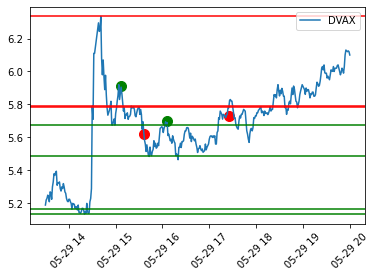

ZNGA analysis for run 1250 with profit 28.85


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4881.42,-4881.42,buy,2020-05-29 14:37:30.811353,8.46,[8.33],[8.526],577,"{'avg': 8.4014, 'rsi': 63.61411453998662, 'macd': [0.009018156135603306, 0.009532384175610531, 0.009922364729170852, 0.011742180094731935, 0.014198819710543376], 'vwap': 8.4501, 'supports': [8.33, 8.45], 'sell_macd': [0.004605095201080545, 0.005010547259757914, 0.005323749548859169, 0.006558403935837731, 0.008193739770680608], 'slow macd': [0.03379110924809581, 0.03334633044603841, 0.03290297924839081, 0.0327687277398816, 0.03282630965429867], 'macd_signal': [0.00278632240270014, 0.0041355347572822184, 0.005292900751659945, 0.006582756620274343, 0.00810596923832815], 'resistances': [8.49, 8.526], 'position_ratio': '3.0', 'sell_macd_signal': [-7.660513249978197e-05, 0.0009408253459517572, 0.0018174101865332396, 0.0027656089363941377, 0.003851235103251432]}",8.94,8.3
1,28.85,4910.27,sell,2020-05-29 14:53:10.040009,8.51,None,None,577,"{'avg': 8.418, 'rsi': [65.22937246160126, 63.094257762313354], 'vwap': 8.5145, 'reasons': 'bail', 'movement': 0.006501182033096893, 'sell_macd': [0.018411976376127015, 0.017888696317266195, 0.01802784566987725, 0.017382665351522775, 0.016394438280709522], 'sell_macd_signal': [0.015488940808504577, 0.0159688919102569, 0.01638068266218097, 0.01658107920004933, 0.016543751016181368]}",8.94,8.3


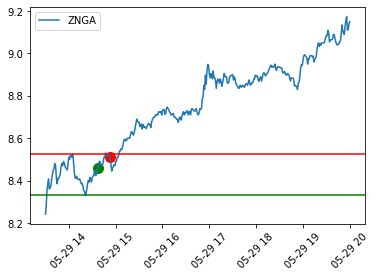

SNOA analysis for run 1250 with profit -464.1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-933.3,-933.3,buy,2020-05-29 15:23:33.230996,15.30,[13.85],"[17.4, 17.6201, 17.92, 19.454]",61,"{'avg': 15.7433, 'rsi': 58.639414458880836, 'macd': [-0.10545113264171846, -0.09997406687389088, -0.06423022256150368, -0.044268746561069605, 0.00936795112087907], 'vwap': 15.2584, 'supports': [13.85], 'sell_macd': [-0.046407350788609136, -0.04349426025158465, -0.020919199310375447, -0.008770850533972308, 0.02522488683119839], 'slow macd': [0.22825639529068198, 0.21708709183877417, 0.21254134389387325, 0.20625988391914696, 0.20766784915804237], 'macd_signal': [-0.21586683460749392, -0.19268828106077332, -0.1669966693609194, -0.14245108480094942, -0.11208727761658373], 'resistances': [17.4, 17.6201, 17.92, 19.454], 'position_ratio': '1.45', 'sell_macd_signal': [-0.1197536027051069, -0.10450173421440245, -0.08778522723359705, -0.07198235189367211, -0.05254090414869801]}",19.83,13.79
1,-464.1,469.2,sell,2020-05-29 15:31:45.118681,15.64,None,None,30,"{'avg': 15.7211, 'rsi': [55.269671606955384, 61.661616864005545], 'vwap': 15.5888, 'reasons': 'scale-out', 'movement': 0.020901960784313656, 'sell_macd': [0.06696546555901506, 0.06816631086624447, 0.07522974473075728, 0.07975670949880964, 0.1050951663375681], 'sell_macd_signal': [0.008575557446623167, 0.020493708130547426, 0.0314409154505894, 0.04110407426023345, 0.05390229267570038]}",19.83,13.79


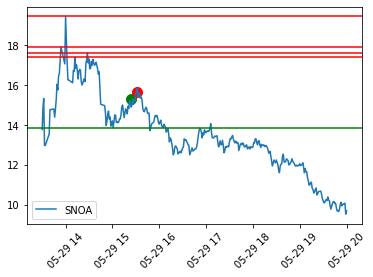

SLGG analysis for run 1253 with profit 44.13


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4148.22,-4148.22,buy,2020-05-29 15:54:17.246449,2.82,"[2.775, 2.785]",[2.8405],1471,"{'avg': 2.8145, 'rsi': 63.94017370522664, 'macd': [-0.0002974713084151759, 0.00040718373698567234, 0.0021512048268355066, 0.003501065169859263, 0.005308493470862263], 'vwap': 2.82, 'supports': [2.7002, 2.71, 2.73, 2.75, 2.7501, 2.76, 2.775, 2.785, 2.7903, 2.7915, 2.81], 'sell_macd': [-0.00033200617659723264, 0.00013928994673140238, 0.0012839454980690945, 0.0021644050770586176, 0.003336654033712083], 'slow macd': [0.0010640594280859617, 0.0011772043860927006, 0.0015193226311258634, 0.0018332517759866995, 0.0022774812662791355], 'macd_signal': [-0.00017989998679106086, -6.248324203571422e-05, 0.00038025437173853, 0.0010044165313626767, 0.001865231919262594], 'resistances': [2.8405], 'position_ratio': '2.05', 'sell_macd_signal': [-0.0003093807087586947, -0.00021964657766067525, 8.107183748527877e-05, 0.0004977384853999465, 0.0010655215950623738]}",3.01,2.76
1,44.13,4192.35,sell,2020-05-29 16:11:39.257967,2.85,None,None,1471,"{'avg': 2.8252, 'rsi': [63.89191047998437, 58.63281663124792], 'vwap': 2.8501, 'reasons': 'bail', 'movement': 0.010673758865248233, 'sell_macd': [0.011082523103139064, 0.010894942717350364, 0.010856634069757565, 0.010696177538259466, 0.00991794936386814], 'sell_macd_signal': [0.009435571940651331, 0.009727446095991138, 0.009953283690744424, 0.010101862460247432, 0.010065079840971573]}",3.01,2.76


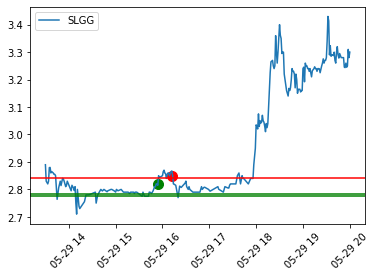

FLGT analysis for run 1253 with profit 65.34


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5108.40,-5108.40,buy,2020-05-29 15:15:22.166395,17.20,"[16.87, 16.88, 17.08, 17.11]",[17.39],297,"{'avg': 16.9968, 'rsi': 62.06008429765858, 'macd': [-0.029017753013881986, -0.027042066473736526, -0.021077730107826653, -0.006240968224474841, 0.009770067077006672], 'vwap': 17.1991, 'supports': [16.0, 16.01, 16.43, 16.59, 16.88, 17.08, 17.11], 'sell_macd': [-0.018659393762586518, -0.017188079074326623, -0.013143053614978584, -0.0033580590542534594, 0.007120612798967585], 'slow macd': [0.0330932849419483, 0.03150715746862787, 0.030821148693743083, 0.032130308715419886, 0.03414864377140603], 'macd_signal': [-0.031188289955799597, -0.030359045259386982, -0.028502782229074916, -0.0240504194281549, -0.017286322127122583], 'resistances': [17.39], 'position_ratio': '2.11', 'sell_macd_signal': [-0.02125573976150293, -0.02044220762406767, -0.018982376822249854, -0.015857513268650574, -0.011261888055126942]}",18.13,16.89
1,65.34,5173.74,sell,2020-05-29 15:48:00.300566,17.42,None,None,297,"{'avg': 17.0489, 'rsi': [64.52498996481155, 58.936172221128224], 'vwap': 17.42, 'reasons': 'bail', 'movement': 0.012790697674418745, 'sell_macd': [0.05921550516564977, 0.0586066912788894, 0.05763090524662218, 0.057213008270224464, 0.05323525727211731], 'sell_macd_signal': [0.0496483997786045, 0.051440058078661484, 0.05267822751225362, 0.05358518366384779, 0.05351519838550169]}",18.13,16.89


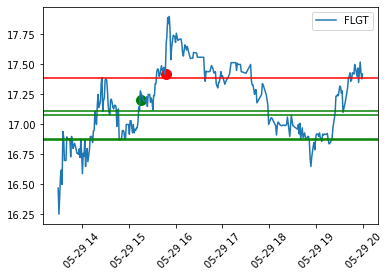

TRVI analysis for run 1253 with profit -3828.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3828.0,-3828.0,buy,2020-05-29 16:05:53.188733,2.9,"[2.8, 2.825, 2.85, 2.87]",[2.9868],1320,"{'avg': 2.8771, 'rsi': 61.1828714454705, 'macd': [0.01600966558166661, 0.014705465084716707, 0.013691570506368933, 0.015533202155739279, 0.016799059406320094], 'vwap': 2.922, 'supports': [2.77, 2.7827, 2.783, 2.79, 2.8, 2.8014, 2.825, 2.85, 2.85, 2.87], 'sell_macd': [0.009581675482580376, 0.00869050960501383, 0.00799751658866299, 0.009171839996848785, 0.009967782392878544], 'slow macd': [0.008548820941245872, 0.008670152236440298, 0.008803100137798392, 0.009471113220754557, 0.010070558902881555], 'macd_signal': [0.017733692467173417, 0.017128046990682076, 0.016440751693819446, 0.016259241786203412, 0.01636720531022675], 'resistances': [2.9868, 2.99], 'position_ratio': '0.95', 'sell_macd_signal': [0.010980725297448323, 0.010522682158961424, 0.010017649044901737, 0.009848487235291147, 0.009872346266808626]}",3.14,2.85


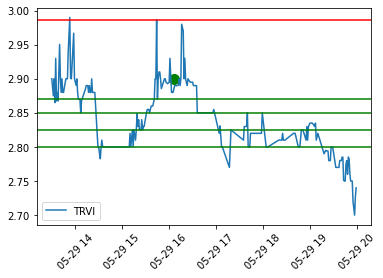

GFI analysis for run 1251 with profit -97.74


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8459.94,-8459.94,buy,2020-05-29 14:41:41.654539,7.79,"[7.685, 7.7, 7.72]",[7.8054],1086,"{'avg': 7.7407, 'rsi': 64.30251023429108, 'macd': [0.005715613952673948, 0.006684033663652222, 0.009360897725943396, 0.010593644239408562, 0.012994301544951625], 'vwap': 7.79, 'supports': [7.44, 7.46, 7.465, 7.685, 7.7, 7.72], 'sell_macd': [0.0025095339269647354, 0.003195326069111104, 0.004986913114040981, 0.005824683368350847, 0.007414833133158716], 'slow macd': [0.02616150988482069, 0.025900103958445442, 0.026018018611615013, 0.025932952455076652, 0.026125087986458517], 'macd_signal': [0.00792267225698186, 0.007674944538315932, 0.008012135175841425, 0.008528436988554853, 0.009421609899834208], 'resistances': [7.865], 'position_ratio': '1.07', 'sell_macd_signal': [0.00369486435202279, 0.0035949566954404525, 0.0038733479791605583, 0.004263615056998616, 0.004893858672230636]}",8.04,7.7
1,-97.74,8362.20,sell,2020-05-29 15:03:38.224622,7.70,None,None,1086,"{'avg': 7.7509, 'rsi': [33.51527094975387, 30.93351925931005], 'vwap': 7.7094, 'reasons': 'stopped', 'movement': -0.011553273427471098, 'sell_macd': [0.005528475868903371, 0.0041407336065004685, 0.0019666391993489185, -0.0018309231854356511, -0.005545505262080752], 'sell_macd_signal': [0.008525918611223662, 0.007648881610279023, 0.006512433128093002, 0.004843761865387271, 0.0027659084398936663]}",8.04,7.7


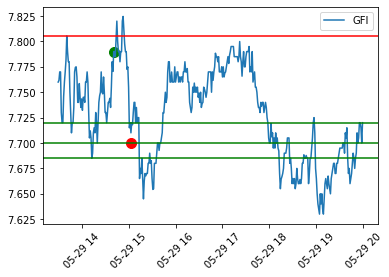

SRTY analysis for run 1251 with profit 112.86


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-13717.62,-13717.62,buy,2020-05-29 16:08:27.156690,13.37,[13.29],"[13.4499, 13.57]",1026,"{'avg': 13.2874, 'rsi': 57.09026359822303, 'macd': [-0.0011076773851730337, 9.131981614629581e-05, 0.0018273852038888094, 0.004762167086550306, 0.00700722791100894], 'vwap': 13.37, 'supports': [13.12, 13.22, 13.26, 13.26, 13.27, 13.29], 'sell_macd': [-0.00015641452234582687, 0.0005874547268991392, 0.0016789443402469573, 0.003546612294281104, 0.004955878072824049], 'slow macd': [0.0014834029973389562, 0.0015756655874294978, 0.0018179660902060135, 0.002357854771746659, 0.0028507985690833237], 'macd_signal': [-0.0015581089589570165, -0.001228223203936354, -0.0006171015223713212, 0.0004587521994130043, 0.0017684473417321916], 'resistances': [13.57], 'position_ratio': '2.5', 'sell_macd_signal': [-0.00027639307793875186, -0.00010362351697117364, 0.00025289005447245256, 0.0009116345024341829, 0.0017204832165121564]}",13.64,13.27
1,112.86,13830.48,sell,2020-05-29 16:27:15.176030,13.48,None,None,1026,"{'avg': 13.303, 'rsi': [61.19092223508773, 56.95027198175534], 'vwap': 13.4808, 'reasons': 'bail', 'movement': 0.00828721017202701, 'sell_macd': [0.031236805249866606, 0.030285574790749337, 0.02915103709804967, 0.027368916336230953, 0.02462740773823846], 'sell_macd_signal': [0.02386503661745801, 0.025149144252116278, 0.025949522821302955, 0.026233401524288553, 0.025912202767078535]}",13.64,13.27


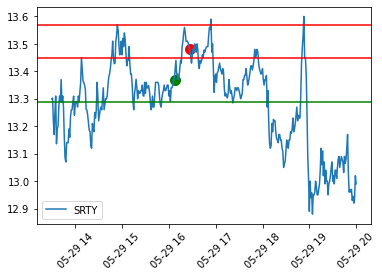

In [18]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))